In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [173]:
def generate_index(X): 
    rweights = np.random.uniform(0,1,X.shape[1])
    rweights = rweights/np.sum(rweights)

    portfolio = np.dot(X,rweights)

    return portfolio, rweights 

In [207]:
import statsmodels.api as sm

def ols_regression(X, y):
    # Add a constant column to the X matrix
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Return the fitted values
    return results


In [175]:
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha):
    # Create a Ridge regression model
    model = Ridge(alpha=alpha)

    # Fit the model to the data
    model.fit(X, y)

    # Predict the target variable
    y_pred = model.predict(X)

    return y_pred

In [176]:
def compute_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [177]:
def compute_negative_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    negative_drawdown = np.min(drawdown)
    return negative_drawdown

### Tried autoencoder with cross validation on how many non communal stocks do we pick (not working) 


In [7]:
from sklearn.model_selection import TimeSeriesSplit

def autoencoder_cross_val(X, Y):
    # Prepare the data
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
    Y_train, Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

    X_train_normalized = (X_train - X_train.mean()) / X_train.std()
    X_test_normalized = (X_test - X_test.mean()) / X_test.std()

    l = len(X_train_normalized[1])
    Nb_most_comm = l/10 #take care of the trend 
    folds = 5 # 5 different numbers of least communal for cross validation  
    validation_itr_train = TimeSeriesSplit(n_splits=folds).split(X_train_normalized)
    validation_itr_test = TimeSeriesSplit(n_splits=folds).split(X_test_normalized)
    score = float('inf')

    for i, (train_idx, test_idx) in enumerate(zip(validation_itr_train, validation_itr_test)):
        print(len(X_train_normalized))
        print(len(X_test_normalized))
        print(train_idx)
        print(test_idx)

        # Build the autoencoder model

        input_dim = X_train_normalized[train_idx].shape[1]

        input_layer = layers.Input(shape=(input_dim,))
        encoder = layers.Dense(30, activation='relu')(input_layer)
        decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

        autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

        # Compile and train the autoencoder
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_train_normalized[train_idx],X_train_normalized[train_idx], epochs=10, batch_size=32, validation_data=(X_test_normalized[test_idx],X_test_normalized[test_idx]))

        print(len(X_train_normalized))
        print(len(X_train_normalized))
        print(train_idx)
        print(test_idx)

        # Extract the decoded features
        decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
        decoded_features_test = decoder_model.predict(X_test_normalized)
        decod_error = abs(decoded_features_test-X_test_normalized)

        sum_of_squares = np.sum(decod_error**2, axis=0)
        print(sum_of_squares.shape)

        #CROSS VALIDATION PARAMETER 
        Nb_least_comm =  (i+1)*l/10  
        Nb_most_comm = int(Nb_most_comm)
        Nb_least_comm = int(Nb_least_comm)

        # Get the indices of the features with the smallest average decoding error
        most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

        # Get the indices of the features with the highest average decoding error
        least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

        selected_features = np.concatenate((most_comm_indices, least_comm_indices))
        #print(selected_features)
        selected_X_test_normalized = X_test_normalized[selected_features,test_idx]

        # De-normalize the selected_X_test_normalized
        selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

        # Run OLS regression
        predicted_values = ols_regression(selected_X_test_denormalized.T, Y_test[test])

        #CROSS VALIDATION 

        # Compute MSE
        mse = compute_mse(predicted_values, Y_test)
 
        # Compute negative drawdown
        negative_drawdown = compute_negative_drawdown(predicted_values)

        #SELECTION CRITERIA, MUST IMPOSE PENALTY ON NUMBER OF SELCTED FEATURES (MIGHT WANT TO ACCOUNT FOR FIXED T COSTS HERE ??)

        score_n = (mse+negative_drawdown+(mse+negative_drawdown)*(Nb_least_comm/(Nb_least_comm + Nb_most_comm)))/3

        # Check if the current score is smaller than the previous iteration score 
        if score_n < score:
            score = score_n
            Nb_least_comm_val = Nb_least_comm

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test_normalized = X_test_normalized[selected_features, :]

    # De-normalize the selected_X_test_normalized
    selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

    # Print the selected features and their shape
    print("Nb_least_comm_val:", Nb_least_comm_val)
    print("Nb_most_comm:", Nb_most_comm)
    print("Shape of selected_X_test_denormalized:", selected_X_test_denormalized.shape)

    # Return the de-normalized array
    return selected_X_test_denormalized, Nb_most_comm, Nb_least_comm_val

### Simple autoencoder

In [255]:
from tensorflow.keras import regularizers

def sparse_autoencoder(X):
    # Prepare the data
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]

    #X_train_normalized = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)

    l = len(X_train.values[1])
    
    Nb_most_comm = 5
    Nb_least_comm =  20

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    print(input_dim)
    hidden_dim = 20

    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis = 1)(input_layer)
    encoder = layers.Dense(hidden_dim, activation='relu')(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    print(X_train.shape)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_test, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test)
    decod_error = abs(decoded_features_test - X_test)

    print(decod_error.mean(axis=0))
    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    print(percentage_error)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = X_test.columns[np.argsort(sum_of_squares)[:Nb_most_comm]]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = X_test.columns[np.argsort(sum_of_squares)[-Nb_least_comm:]]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test = X_test[selected_features]
    selected_X_train = X_train[selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)
    print("Number of features in selected X_train:", selected_X_train.shape)
    print("Most communal features:", len(most_comm_indices))
    print("Least communal features:", len(least_comm_indices))

    # Return the de-normalized arrays
    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history


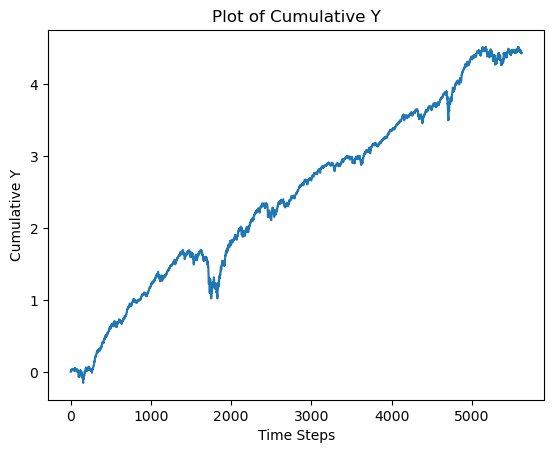

In [191]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]
returns.shape
#X = returns.iloc[:, :-900]
X = returns[returns.columns[-100:]]

index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index
cumulative_y = np.cumsum(Y)

plt.plot(cumulative_y)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Y')
plt.title('Plot of Cumulative Y')
plt.show()



In [192]:
print(X.shape)
print(Y.shape)

(5621, 100)
(5621,)


In [218]:
Y

array([ 0.00580199,  0.01593041,  0.0015034 , ..., -0.00414305,
       -0.00581575,  0.00487618])

In [219]:
X

,489,3412,4010,6006,6017,6153,6185,6606,5978,6422,...,6801,6802,6803,6806,6821,6822,6823,6824,6825,6830
2002-03-06,0.006932,0.008273,0.004998,-0.040340,0.022407,0.282443,0.015157,0.055844,-0.040147,-0.000638,...,0.038855,0.004979,-0.003386,-0.007066,0.030230,-0.027764,-0.029382,0.009958,0.005976,0.004521
2002-03-07,0.008485,-0.012821,0.060707,0.022268,0.027397,0.455357,-0.009954,0.009167,0.068746,0.092516,...,-0.001098,-0.020350,-0.001699,0.025953,0.071353,-0.000985,0.021341,0.023613,-0.009862,0.003809
2002-03-08,0.011442,0.000779,0.044123,0.000222,-0.028003,0.098160,-0.001077,-0.002699,-0.031586,0.003353,...,-0.006625,-0.006983,-0.069221,0.000129,0.023661,0.039921,0.006149,0.093657,0.000000,-0.006642
2002-03-11,0.009043,0.002855,0.005530,-0.013556,0.056245,-0.009311,-0.026959,-0.005737,-0.005333,0.011494,...,-0.000369,-0.001763,0.029835,-0.005824,-0.035733,-0.033649,0.012302,-0.023487,0.004200,0.020647
2002-03-12,-0.001038,0.011646,-0.020631,-0.005181,0.025974,-0.080827,0.038050,-0.010722,-0.010315,-0.026910,...,-0.000369,0.030119,-0.023646,0.001439,0.008681,-0.041687,-0.008276,0.009019,-0.000239,-0.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,0.002254,0.003984,0.008145,0.013740,0.018502,0.030590,0.011617,0.004296,-0.030266,0.001995,...,0.011449,0.007766,0.012627,-0.027975,0.001816,0.025259,0.011543,0.029024,0.005581,0.005394
2023-09-15,-0.015444,0.000529,-0.001003,-0.013299,-0.017296,-0.003062,-0.011078,-0.000742,0.014744,-0.001326,...,-0.018352,-0.008188,-0.029646,-0.016934,0.002702,-0.050901,0.004280,-0.009271,-0.026131,-0.012850
2023-09-18,-0.019393,-0.025248,0.002767,-0.003613,-0.000443,-0.013981,-0.003552,0.001490,0.001490,0.001490,...,0.010037,-0.008984,0.009553,0.001472,-0.002217,-0.006975,-0.002417,0.016843,0.006464,0.005570
2023-09-19,0.012051,-0.016816,-0.007950,-0.008534,-0.006534,-0.007531,0.001097,-0.008252,-0.017058,0.001254,...,0.018130,-0.015068,-0.021039,-0.000899,0.004582,-0.007830,-0.013948,-0.007669,0.009919,-0.062576


100
(4496, 100)
Epoch 1/100
71/71 [==============================] - 1s 7ms/step - loss: 0.1796 - val_loss: 0.1238
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0281 - val_loss: 0.0039
Epoch 3/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 4/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.0883e-04
Epoch 5/100
71/71 [==============================] - 0s 2ms/step - loss: 8.7553e-04 - val_loss: 6.3059e-04
Epoch 6/100
71/71 [==============================] - 0s 4ms/step - loss: 7.3245e-04 - val_loss: 6.0356e-04
Epoch 7/100
71/71 [==============================] - 0s 2ms/step - loss: 6.6555e-04 - val_loss: 5.9375e-04
Epoch 8/100
71/71 [==============================] - 0s 2ms/step - loss: 6.1905e-04 - val_loss: 5.9254e-04
Epoch 9/100
71/71 [==============================] - 0s 3ms/step - loss: 5.9240e-04 - val_loss: 5.9583e-04
Epoch 10/100
71/71 [=============================

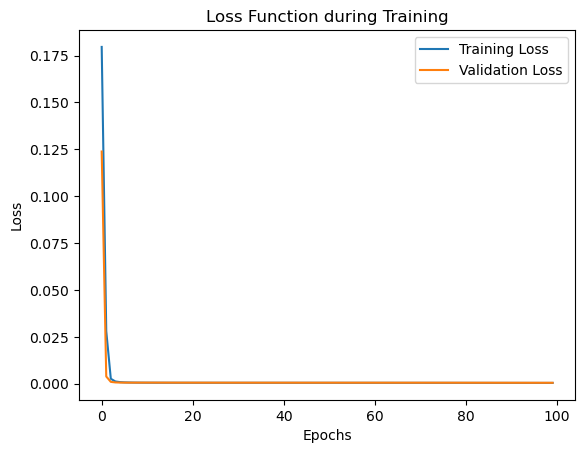

In [256]:
Res = sparse_autoencoder(X)
history = Res[4]
# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function during Training')
plt.legend()
plt.show()


array([-0.00090127, -0.00613417,  0.00418295, ..., -0.00414305,
       -0.00581575,  0.00487618])

(26,)


2019-05-30   -0.006553
2019-05-31   -0.007616
2019-06-03    0.005001
2019-06-04    0.018264
2019-06-05    0.002249
                ...   
2023-09-14    0.009867
2023-09-15   -0.009703
2023-09-18   -0.004278
2023-09-19   -0.004862
2023-09-20    0.001137
Length: 1125, dtype: float64

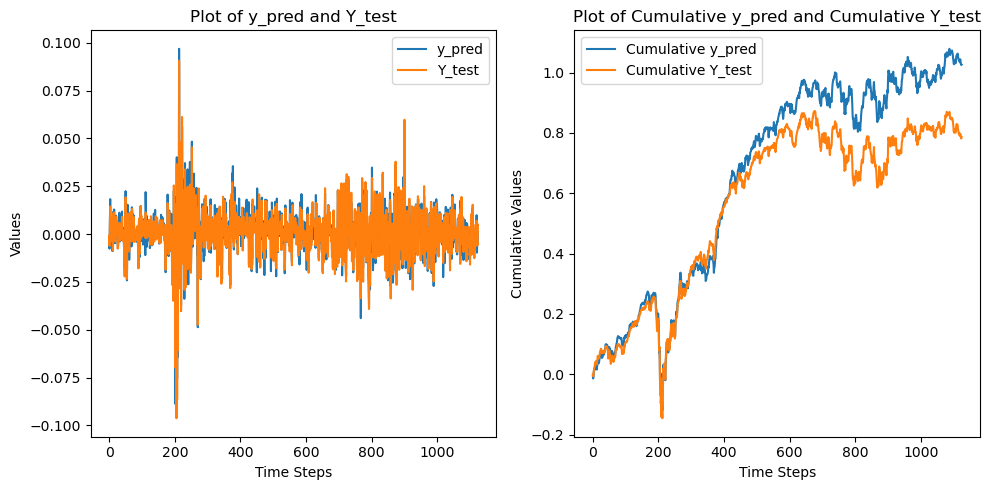

Number of selected features: 25
Tracking Error: 1.668061104535784e-05


In [257]:
selected_X_test, selected_X_train, _,_, Nb_least_comm_val = Res


Y_test = Y[int(len(Y)*0.8):]
Y_train = Y[:int(len(Y)*0.8)]
display(Y_test)

results = ols_regression(selected_X_train,Y_train)
coeff = results.params
print(coeff.shape)

#do regression using fitted coefficient to predict y on test set 
predicted_values = results.predict(sm.add_constant(selected_X_test))



display(predicted_values)

# Plot the predicted values and Y_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(predicted_values.values, label='y_pred')
plt.plot(Y_test, label='Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Plot of y_pred and Y_test')
plt.legend()

# Compute the cumulative values
cumulative_predicted_values = np.cumsum(predicted_values.values)
cumulative_Y_test = np.cumsum(Y_test)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", len(selected_X_test.columns))

tracking_error = compute_mse(predicted_values, Y_test)
print("Tracking Error:", tracking_error)



random selection process, just to compare 



In [220]:
coeff

const    0.000190
6606     0.021488
3185     0.029395
51       0.080278
5276     0.070320
6437     0.039851
412      0.026913
29       0.077806
2815     0.022998
2820     0.050203
6738     0.021219
2718     0.015456
6342     0.031296
2333     0.024902
2478     0.030537
6723     0.028724
6163     0.063561
2576     0.039439
6736     0.008258
2321     0.029165
6803     0.017046
6822     0.015711
6673     0.038804
6091     0.032116
6765    -0.000716
6658     0.018354
dtype: float64

In [254]:
import random
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]

def random_feature_selection(X, num_features):
    # Get the column names of X
    columns = X.columns.tolist()

    # Select num_features randomly from the columns
    selected_features = random.sample(columns, num_features)

    # Return the selected features
    return X[selected_features]


X_test = X[int(len(X)*0.8):]

num_iterations = 10  # Number of iterations to repeat the code block
tracking_errors = []  # List to store tracking errors

for _ in range(num_iterations):
    # Perform the same task as the previous cell
    selected_X_train_random = random_feature_selection(X_train, len(selected_X_train.columns))
    results = ols_regression(selected_X_train_random, Y_train)

    # Get the predicted values
    predicted_values_random = results.predict(sm.add_constant(X_test[selected_X_train_random.columns]))
    

    tracking_error_random = compute_mse(predicted_values_random, Y_test)
    tracking_errors.append(tracking_error_random)

mean_tracking_error = sum(tracking_errors) / len(tracking_errors)
print("Mean Average Tracking Error for random selection sample:", mean_tracking_error)


Mean Average Tracking Error for random selection sample: 9.990882187872354e-06
